In [3]:
"""
Enhanced NAL (Non-Axiomatic Logic) Learning Rate Scheduler

This module implements a learning rate scheduler for neural network training that uses
Non-Axiomatic Logic reasoning to dynamically adjust learning rates based on training metrics.
"""

import numpy as np
import random
import torch
from collections import deque
from enum import Enum
from typing import Dict, List, Tuple, Set, Optional, Union
from dataclasses import dataclass
import copy
import time
import math


# NAL Term Types (for NAL-2 and above)
class TermType(Enum):
    ATOM = 0          # Atomic term (e.g., "x")
    COMPOUND = 1      # Compound term (e.g., intersection, difference)
    STATEMENT = 2     # Statement with a copula (e.g., inheritance)


# Copula Types (NAL-2 and above)
class CopulaType(Enum):
    INHERITANCE = 0   # Inheritance relation (-->)
    SIMILARITY = 1    # Similarity relation (<->)
    IMPLICATION = 2   # Implication relation (==>)
    EQUIVALENCE = 3   # Equivalence relation (<==>)
    INSTANCE = 4      # Instance relation (e.g., {John} --> Human)
    PROPERTY = 5      # Property relation (e.g., Red --> [Color])


# Connective Types (NAL-3 and above)
class ConnectiveType(Enum):
    CONJUNCTION = 0   # Logical AND
    DISJUNCTION = 1   # Logical OR
    NEGATION = 2      # Logical NOT
    SEQUENTIAL = 3    # Sequential conjunction (for NAL-7)
    PARALLEL = 4      # Parallel conjunction (for NAL-7)


@dataclass
class TruthValue:
    """Truth value in Non-Axiomatic Logic with frequency and confidence"""
    f: float  # frequency
    c: float  # confidence
    
    def __post_init__(self):
        self.f = float(np.clip(self.f, 0.0, 1.0))
        self.c = float(np.clip(self.c, 0.0, 1.0))
    
    def __str__(self):
        return f"TV({self.f:.2f}, {self.c:.2f})"
    
    @property
    def expectation(self) -> float:
        """Calculate the expectation (strength) of the truth value (NAL-1)"""
        return self.c * (self.f - 0.5) + 0.5
    
    @property
    def evidence(self) -> float:
        """Calculate the amount of evidence represented (NAL-1)"""
        if self.c == 0:
            return 0
        return self.c / (1 - self.c)
    
    # Explicitly define method versions that call the properties
    # This helps with code that might call them as methods
    def expectation_method(self):
        return self.expectation
    
    def evidence_method(self):
        return self.evidence
    
    @classmethod
    def revision(cls, tv1: 'TruthValue', tv2: 'TruthValue') -> 'TruthValue':
        """Truth value revision (NAL-1)"""
        if tv1.c == 0:
            return tv2
        if tv2.c == 0:
            return tv1
            
        w1 = tv1.evidence  # Using property
        w2 = tv2.evidence  # Using property
        w = w1 + w2
        
        f = (w1 * tv1.f + w2 * tv2.f) / w
        c = w / (w + 1)
        
        return cls(f, c)
    
    @classmethod
    def deduction(cls, tv1: 'TruthValue', tv2: 'TruthValue') -> 'TruthValue':
        """Deduction inference (NAL-2)"""
        f = tv1.f * tv2.f
        c = tv1.c * tv2.c * tv1.f
        return cls(f, c)
    
    @classmethod
    def abduction(cls, tv1: 'TruthValue', tv2: 'TruthValue') -> 'TruthValue':
        """Abduction inference (NAL-2)"""
        f = tv1.f
        c = tv1.c * tv2.c * tv2.f
        return cls(f, c)
    
    @classmethod
    def induction(cls, tv1: 'TruthValue', tv2: 'TruthValue') -> 'TruthValue':
        """Induction inference (NAL-2)"""
        f = tv2.f
        c = tv1.c * tv2.c * tv1.f
        return cls(f, c)
    
    @classmethod
    def exemplification(cls, tv1: 'TruthValue', tv2: 'TruthValue') -> 'TruthValue':
        """Exemplification inference (NAL-2)"""
        f = 1.0
        c = tv1.c * tv2.c * tv1.f * tv2.f
        return cls(f, c)
    
    @classmethod
    def intersection(cls, tv1: 'TruthValue', tv2: 'TruthValue') -> 'TruthValue':
        """Intersection (NAL-3)"""
        f = tv1.f * tv2.f
        c = tv1.c * tv2.c
        return cls(f, c)
    
    @classmethod
    def union(cls, tv1: 'TruthValue', tv2: 'TruthValue') -> 'TruthValue':
        """Union (NAL-3)"""
        f = tv1.f + tv2.f - tv1.f * tv2.f
        c = tv1.c * tv2.c
        return cls(f, c)
    
    @classmethod
    def negation(cls, tv: 'TruthValue') -> 'TruthValue':
        """Negation (NAL-3)"""
        return cls(1.0 - tv.f, tv.c)


class Term:
    """Base class for NAL terms (NAL-2 and above)"""
    def __init__(self, name: str, term_type: TermType = TermType.ATOM):
        self.name = name
        self.term_type = term_type
    
    def __str__(self):
        return self.name
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self.name})"
    
    def __eq__(self, other):
        if not isinstance(other, Term):
            return False
        return self.name == other.name and self.term_type == other.term_type
    
    def __hash__(self):
        return hash((self.name, self.term_type))


class AtomicTerm(Term):
    """Atomic term with no internal structure (NAL-1)"""
    def __init__(self, name: str):
        super().__init__(name, TermType.ATOM)


class CompoundTerm(Term):
    """Compound term with connective and components (NAL-3)"""
    def __init__(self, 
                 connective: ConnectiveType, 
                 components: List[Term],
                 name: Optional[str] = None):
        self.connective = connective
        self.components = components
        
        # Generate name if not provided
        if name is None:
            if connective == ConnectiveType.CONJUNCTION:
                connector = "&&"
            elif connective == ConnectiveType.DISJUNCTION:
                connector = "||"
            elif connective == ConnectiveType.NEGATION:
                connector = "~"
                if len(components) == 1:
                    name = f"{connector}{components[0]}"
            elif connective == ConnectiveType.SEQUENTIAL:
                connector = "&/"
            else:  # PARALLEL
                connector = "&|"
                
            if name is None:
                name = f"({connector.join(str(c) for c in components)})"
                
        super().__init__(name, TermType.COMPOUND)
    
    @classmethod
    def conjunction(cls, terms: List[Term]) -> 'CompoundTerm':
        """Create a conjunction compound term (NAL-3)"""
        return cls(ConnectiveType.CONJUNCTION, terms)
    
    @classmethod
    def disjunction(cls, terms: List[Term]) -> 'CompoundTerm':
        """Create a disjunction compound term (NAL-3)"""
        return cls(ConnectiveType.DISJUNCTION, terms)
    
    @classmethod
    def negation(cls, term: Term) -> 'CompoundTerm':
        """Create a negation compound term (NAL-3)"""
        return cls(ConnectiveType.NEGATION, [term])
    
    @classmethod
    def sequential(cls, terms: List[Term]) -> 'CompoundTerm':
        """Create a sequential conjunction (NAL-7)"""
        return cls(ConnectiveType.SEQUENTIAL, terms)
    
    @classmethod
    def parallel(cls, terms: List[Term]) -> 'CompoundTerm':
        """Create a parallel conjunction (NAL-7)"""
        return cls(ConnectiveType.PARALLEL, terms)


class Statement(Term):
    """Statement with subject, predicate and copula (NAL-2)"""
    def __init__(self, 
                 subject: Term, 
                 predicate: Term, 
                 copula: CopulaType,
                 name: Optional[str] = None):
        self.subject = subject
        self.predicate = predicate
        self.copula = copula
        
        # Generate name if not provided
        if name is None:
            if copula == CopulaType.INHERITANCE:
                connector = "-->"
            elif copula == CopulaType.SIMILARITY:
                connector = "<->"
            elif copula == CopulaType.IMPLICATION:
                connector = "==>"
            elif copula == CopulaType.EQUIVALENCE:
                connector = "<==>"
            elif copula == CopulaType.INSTANCE:
                connector = ":{-->"
            else:  # PROPERTY
                connector = "--{:"
                
            name = f"({subject} {connector} {predicate})"
            
        super().__init__(name, TermType.STATEMENT)
    
    @classmethod
    def inheritance(cls, subject: Term, predicate: Term) -> 'Statement':
        """Create an inheritance statement (NAL-2)"""
        return cls(subject, predicate, CopulaType.INHERITANCE)
    
    @classmethod
    def similarity(cls, term1: Term, term2: Term) -> 'Statement':
        """Create a similarity statement (NAL-2)"""
        return cls(term1, term2, CopulaType.SIMILARITY)
    
    @classmethod
    def implication(cls, condition: Term, prediction: Term) -> 'Statement':
        """Create an implication statement (NAL-5)"""
        return cls(condition, prediction, CopulaType.IMPLICATION)
    
    @classmethod
    def equivalence(cls, term1: Term, term2: Term) -> 'Statement':
        """Create an equivalence statement (NAL-5)"""
        return cls(term1, term2, CopulaType.EQUIVALENCE)


class TemporalStatement(Statement):
    """Temporal statement with subject, predicate, copula and time (NAL-7)"""
    def __init__(self,
                 subject: Term,
                 predicate: Term,
                 copula: CopulaType,
                 time_offset: int = 0,
                 name: Optional[str] = None):
        self.time_offset = time_offset
        
        # Generate name if not provided
        if name is None:
            base_statement = Statement(subject, predicate, copula)
            if time_offset == 0:
                name = str(base_statement)
            else:
                name = f"{base_statement} @ {time_offset}"
                
        super().__init__(subject, predicate, copula, name)


class Belief:
    """A belief consisting of a term and its truth value (NAL-1)"""
    def __init__(self, term: Union[str, Term], tv: TruthValue):
        if isinstance(term, str):
            self.term = AtomicTerm(term)
        else:
            self.term = term
        self.tv = tv
        
    def __str__(self):
        return f"{self.term}: {self.tv}"
    
    def __repr__(self):
        return f"Belief({repr(self.term)}, {repr(self.tv)})"


class NALEngine:
    """Non-Axiomatic Logic reasoning engine"""
    def __init__(self):
        self.beliefs = {}  # Dictionary mapping terms to truth values
        self.inference_rules = {
            "deduction": TruthValue.deduction,
            "abduction": TruthValue.abduction,
            "induction": TruthValue.induction,
            "exemplification": TruthValue.exemplification,
            "revision": TruthValue.revision,
            "intersection": TruthValue.intersection,
            "union": TruthValue.union,
            "negation": TruthValue.negation
        }
        
    def add_belief(self, term: Union[str, Term], frequency: float, confidence: float):
        """Add a belief with given frequency and confidence"""
        if isinstance(term, str):
            term = AtomicTerm(term)
            
        tv = TruthValue(frequency, confidence)
        
        # Check if we already have this belief
        if term in self.beliefs:
            # Revise with existing belief
            tv = TruthValue.revision(self.beliefs[term], tv)
            
        self.beliefs[term] = tv
        
    def add_implication(self, antecedent: Union[str, Term], consequent: Union[str, Term], 
                         frequency: float, confidence: float):
        """Add an implication belief"""
        if isinstance(antecedent, str):
            antecedent = AtomicTerm(antecedent)
        if isinstance(consequent, str):
            consequent = AtomicTerm(consequent)
            
        # Create implication statement
        statement = Statement.implication(antecedent, consequent)
        
        # Add as belief
        self.add_belief(statement, frequency, confidence)
        
    def _get_term_truth_value(self, term: Union[str, Term]) -> TruthValue:
        """Get truth value for a term, or default if not found"""
        if isinstance(term, str):
            term = AtomicTerm(term)
            
        if term in self.beliefs:
            return self.beliefs[term]
        else:
            # Default truth value with zero confidence
            return TruthValue(0.5, 0.0)
            
    def get_belief_strength(self, term: Union[str, Term]) -> float:
        """Get the expectation strength of a belief"""
        tv = self._get_term_truth_value(term)
        return tv.expectation
        
    def _find_matching_statements(self, term_type=None):
        """Find statements of specified type"""
        matching = []
        
        for term in self.beliefs.keys():
            if isinstance(term, Statement):
                if term_type is None or term.copula == term_type:
                    matching.append(term)
                    
        return matching
        
    def _apply_deduction(self, a_b: Statement, b_c: Statement):
        """Apply deduction A-->B, B-->C |- A-->C"""
        if (a_b.copula == CopulaType.INHERITANCE and 
            b_c.copula == CopulaType.INHERITANCE and
            a_b.predicate == b_c.subject):
            
            # Create new statement
            a_c = Statement.inheritance(a_b.subject, b_c.predicate)
            
            # Get truth values
            tv_a_b = self.beliefs[a_b]
            tv_b_c = self.beliefs[b_c]
            
            # Apply deduction
            tv_a_c = TruthValue.deduction(tv_a_b, tv_b_c)
            
            # Add derived belief
            self.add_belief(a_c, tv_a_c.f, tv_a_c.c)
            
            return True
            
        return False
        
    def _apply_induction(self, a_b: Statement, a_c: Statement):
        """Apply induction A-->B, A-->C |- B-->C"""
        if (a_b.copula == CopulaType.INHERITANCE and
            a_c.copula == CopulaType.INHERITANCE and
            a_b.subject == a_c.subject):
            
            # Create new statement
            b_c = Statement.inheritance(a_b.predicate, a_c.predicate)
            
            # Get truth values
            tv_a_b = self.beliefs[a_b]
            tv_a_c = self.beliefs[a_c]
            
            # Apply induction
            tv_b_c = TruthValue.induction(tv_a_b, tv_a_c)
            
            # Add derived belief
            self.add_belief(b_c, tv_b_c.f, tv_b_c.c)
            
            return True
            
        return False
        
    def _apply_abduction(self, a_c: Statement, b_c: Statement):
        """Apply abduction A-->C, B-->C |- A-->B"""
        if (a_c.copula == CopulaType.INHERITANCE and
            b_c.copula == CopulaType.INHERITANCE and
            a_c.predicate == b_c.predicate):
            
            # Create new statement
            a_b = Statement.inheritance(a_c.subject, b_c.subject)
            
            # Get truth values
            tv_a_c = self.beliefs[a_c]
            tv_b_c = self.beliefs[b_c]
            
            # Apply abduction
            tv_a_b = TruthValue.abduction(tv_a_c, tv_b_c)
            
            # Add derived belief
            self.add_belief(a_b, tv_a_b.f, tv_a_b.c)
            
            return True
            
        return False
        
    def _apply_exemplification(self, a_b: Statement, c_a: Statement):
        """Apply exemplification A-->B, C-->A |- C-->B"""
        if (a_b.copula == CopulaType.INHERITANCE and
            c_a.copula == CopulaType.INHERITANCE and
            a_b.subject == c_a.predicate):
            
            # Create new statement
            c_b = Statement.inheritance(c_a.subject, a_b.predicate)
            
            # Get truth values
            tv_a_b = self.beliefs[a_b]
            tv_c_a = self.beliefs[c_a]
            
            # Apply exemplification
            tv_c_b = TruthValue.exemplification(tv_a_b, tv_c_a)
            
            # Add derived belief
            self.add_belief(c_b, tv_c_b.f, tv_c_b.c)
            
            return True
            
        return False
        
    def _apply_conversion(self, a_b: Statement):
        """Apply conversion A-->B |- B-->A"""
        if a_b.copula == CopulaType.INHERITANCE:
            # Create new statement
            b_a = Statement.inheritance(a_b.predicate, a_b.subject)
            
            # Get truth value
            tv_a_b = self.beliefs[a_b]
            
            # Apply conversion (w=1)
            f = tv_a_b.c
            c = tv_a_b.f
            tv_b_a = TruthValue(f, c)
            
            # Add derived belief
            self.add_belief(b_a, tv_b_a.f, tv_b_a.c)
            
            return True
            
        return False
        
    def _apply_implication_deduction(self, s1: Statement, s2: Statement):
        """Apply deduction on implication statements"""
        # For s1: A ==> B, s2: B ==> C |- A ==> C
        if (s1.copula == CopulaType.IMPLICATION and
            s2.copula == CopulaType.IMPLICATION and
            s1.predicate == s2.subject):
            
            # Create new statement
            new_stmt = Statement.implication(s1.subject, s2.predicate)
            
            # Get truth values
            tv_s1 = self.beliefs[s1]
            tv_s2 = self.beliefs[s2]
            
            # Apply deduction
            tv_new = TruthValue.deduction(tv_s1, tv_s2)
            
            # Add derived belief
            self.add_belief(new_stmt, tv_new.f, tv_new.c)
            
            return True
            
        return False
        
    def inference_cycle(self, max_cycles=5):
        """Run inference cycles to derive new beliefs"""
        cycle_count = 0
        total_derived = 0
        
        while cycle_count < max_cycles:
            derived_count = 0
            
            # Get all inheritance statements
            inheritance_stmts = self._find_matching_statements(CopulaType.INHERITANCE)
            
            # Get all implication statements
            implication_stmts = self._find_matching_statements(CopulaType.IMPLICATION)
            
            # Apply syllogistic rules on inheritance statements
            for i, s1 in enumerate(inheritance_stmts):
                for s2 in inheritance_stmts[i+1:]:
                    # Try all possible syllogistic rules
                    if self._apply_deduction(s1, s2) or self._apply_deduction(s2, s1):
                        derived_count += 1
                    if self._apply_induction(s1, s2) or self._apply_induction(s2, s1):
                        derived_count += 1
                    if self._apply_abduction(s1, s2) or self._apply_abduction(s2, s1):
                        derived_count += 1
                    if self._apply_exemplification(s1, s2) or self._apply_exemplification(s2, s1):
                        derived_count += 1
                
                # Apply conversion
                if self._apply_conversion(s1):
                    derived_count += 1
            
            # Apply rules on implication statements
            for i, s1 in enumerate(implication_stmts):
                for s2 in implication_stmts[i+1:]:
                    if self._apply_implication_deduction(s1, s2) or self._apply_implication_deduction(s2, s1):
                        derived_count += 1
            
            # Stop if no new beliefs were derived
            if derived_count == 0:
                break
                
            total_derived += derived_count
            cycle_count += 1
            
        return total_derived
            
    def print_beliefs(self):
        """Print all current beliefs"""
        print("\nCurrent Beliefs:")
        for term, tv in sorted(self.beliefs.items(), key=lambda x: str(x[0])):
            print(f"  {term}: {tv} (exp: {tv.expectation:.3f})")
            
    def select_best_action(self, action_beliefs=None, min_confidence=0.3):
        """Select best action based on belief strengths"""
        if action_beliefs is None:
            # Default action beliefs to look for
            action_beliefs = [
                'should_increase_lr',
                'should_decrease_lr',
                'should_decrease_lr_gently',
                'should_hold_lr', 
                'continue_current_strategy',
                'should_change_strategy'
            ]
            
        best_action = None
        best_strength = -1.0
        
        for action in action_beliefs:
            tv = self._get_term_truth_value(action)
            strength = tv.expectation
            
            # Only consider beliefs with sufficient confidence
            if tv.c >= min_confidence and strength > best_strength:
                best_action = action
                best_strength = strength
                
        return best_action, best_strength


class NALLRTunerFinal:
    def __init__(self, initial_lr=1e-4, lr_min=1e-6, lr_max=0.1, history_len=40):
        # Initialize NAL reasoning engine
        self.engine = NALEngine()
        
        # Learning rate parameters
        self.initial_lr = initial_lr
        self.lr = initial_lr
        self.lr_min = lr_min
        self.lr_max = lr_max
        
        # History tracking with appropriate length
        self.history_len = history_len
        self.recent_lrs = deque(maxlen=history_len)
        self.loss_history = deque(maxlen=history_len)
        self.grad_history = deque(maxlen=history_len)
        self.improvement_history = deque(maxlen=history_len)
        
        # State tracking
        self.epoch = 0
        self.steps = 0
        self.best_loss = float('inf')
        self.loss_plateau_count = 0
        self.consecutive_increases = 0
        self.consecutive_decreases = 0
        
        # Adaptive memory
        self.successful_moves = {'increase': 0, 'decrease': 0, 'hold': 0}
        self.total_moves = {'increase': 0, 'decrease': 0, 'hold': 0}
        self.context_memories = []
        
        # Initialize with first learning rate
        self.recent_lrs.append(initial_lr)
        
        # Performance tracking
        self.validation_history = []
        self.best_accuracy = 0.0
        self.accuracy_not_improved = 0
        
    def on_epoch_start(self):
        """Called at the beginning of each epoch"""
        self.epoch += 1
        
        # Reset batch-level counters
        self.batch_steps = 0
        
        # Add epoch-based NAL beliefs
        self.add_epoch_beliefs()
        
    def add_epoch_beliefs(self):
        """Add epoch-specific beliefs to the NAL engine"""
        # Define training phase based on epoch
        early_training = self.epoch <= 3
        mid_training = 3 < self.epoch <= 10
        late_training = self.epoch > 10
        
        # Add beliefs with high confidence
        self.engine.add_belief('early_training', 1.0 if early_training else 0.0, 0.95)
        self.engine.add_belief('mid_training', 1.0 if mid_training else 0.0, 0.95)
        self.engine.add_belief('late_training', 1.0 if late_training else 0.0, 0.95)
        
        # Add phase-specific implications
        if early_training:
            # In early training, be more exploratory
            self.engine.add_implication('grad_large', 'should_decrease_lr', 0.9, 0.9)
            self.engine.add_implication('step_small', 'should_increase_lr', 0.9, 0.9)
        elif mid_training:
            # In mid training, balance exploration vs exploitation
            self.engine.add_implication('performance_improving', 'continue_current_strategy', 0.8, 0.9)
            self.engine.add_implication('oscillating', 'should_decrease_lr', 0.8, 0.8)
        else:
            # In late training, be more conservative
            self.engine.add_implication('plateau_detected', 'should_decrease_lr', 0.7, 0.8)
            self.engine.add_implication('good_performance', 'should_decrease_lr_gently', 0.8, 0.7)
    
    def detect_plateau(self, window=5, threshold=0.005):
        """Detect if loss has plateaued"""
        if len(self.loss_history) < window + 1:
            return False
            
        recent = list(self.loss_history)[-window:]
        # Calculate relative changes
        rel_changes = [abs(recent[i] - recent[i-1]) / (abs(recent[i-1]) + 1e-10) 
                       for i in range(1, len(recent))]
        
        return max(rel_changes) < threshold
    
    def detect_oscillation(self, window=5):
        """Detect if learning rate is oscillating"""
        if len(self.recent_lrs) < window:
            return False
            
        # Get most recent LR changes
        recent = list(self.recent_lrs)[-window:]
        changes = [np.sign(recent[i] - recent[i-1]) for i in range(1, len(recent))]
        sign_flips = sum(changes[i] != changes[i-1] for i in range(1, len(changes)))
        
        # Consider oscillating if more than half the changes flip sign
        return sign_flips >= (window - 2) // 2
    
    def calculate_trends(self, window=5):
        """Calculate trends in metrics"""
        if len(self.grad_history) < window or len(self.improvement_history) < window:
            return 0.0, 0.0
        
        # Get recent values
        recent_grads = list(self.grad_history)[-window:]
        recent_imps = list(self.improvement_history)[-window:]
        
        # Linear trend calculation (simple slope)
        grad_trend = (recent_grads[-1] - recent_grads[0]) / (window - 1)
        imp_trend = (recent_imps[-1] - recent_imps[0]) / (window - 1)
        
        return grad_trend, imp_trend
    
    def create_context_vector(self):
        """Create a context vector representing current training state"""
        return {
            'epoch_phase': 'early' if self.epoch <= 3 else 'mid' if self.epoch <= 10 else 'late',
            'loss_trend': 'decreasing' if self.loss_is_decreasing() else 'plateau' if self.detect_plateau() else 'increasing',
            'grad_trend': 'decreasing' if self.grad_is_decreasing() else 'stable' if self.grad_is_stable() else 'increasing',
            'oscillating': self.detect_oscillation(),
            'lr_position': 'min' if self.is_near_min_lr() else 'max' if self.is_near_max_lr() else 'mid',
            'accuracy': self.best_accuracy,
        }
        
    def context_similarity(self, ctx1, ctx2):
        """Calculate similarity between two context vectors"""
        # Compare discrete features
        matches = sum(1 for k in ctx1 if k in ctx2 and ctx1[k] == ctx2[k])
        total = len(set(ctx1.keys()).union(ctx2.keys()))
        
        # Special handling for accuracy (continuous)
        if 'accuracy' in ctx1 and 'accuracy' in ctx2:
            acc_diff = abs(ctx1['accuracy'] - ctx2['accuracy'])
            acc_sim = max(0, 1 - acc_diff / 0.2)  # Within 20% is similar
            return (matches + acc_sim) / (total + 1)
        
        return matches / total if total > 0 else 0
    
    def remember_successful_action(self, action, context):
        """Record successful actions with context"""
        self.context_memories.append({
            'context': context,
            'action': action,
            'success': True,
            'lr_factor': self.recent_lrs[-1] / self.recent_lrs[-2] if len(self.recent_lrs) >= 2 else 1.0,
            'confidence': 0.8
        })
        
        # Update success statistics
        self.successful_moves[action] += 1
        self.total_moves[action] += 1
    
    def remember_failed_action(self, action, context):
        """Record failed actions with context"""
        self.context_memories.append({
            'context': context,
            'action': action,
            'success': False,
            'lr_factor': self.recent_lrs[-1] / self.recent_lrs[-2] if len(self.recent_lrs) >= 2 else 1.0,
            'confidence': 0.8
        })
        
        # Update success statistics
        self.total_moves[action] += 1
    
    def get_success_rate(self, action):
        """Get success rate for a particular action"""
        if self.total_moves[action] == 0:
            return 0.5  # Default to neutral
        return self.successful_moves[action] / self.total_moves[action]
    
    def loss_is_decreasing(self, window=3):
        """Check if loss is decreasing over recent iterations"""
        if len(self.loss_history) < window:
            return False
        recent = list(self.loss_history)[-window:]
        return recent[0] > recent[-1]
    
    def grad_is_decreasing(self, window=3):
        """Check if gradient norm is decreasing"""
        if len(self.grad_history) < window:
            return False
        recent = list(self.grad_history)[-window:]
        return recent[0] > recent[-1]
    
    def grad_is_stable(self, window=3, threshold=0.1):
        """Check if gradient norm is stable"""
        if len(self.grad_history) < window:
            return False
        recent = list(self.grad_history)[-window:]
        rel_changes = [abs(recent[i] - recent[i-1]) / (abs(recent[i-1]) + 1e-10) 
                     for i in range(1, len(recent))]
        return max(rel_changes) < threshold
    
    def is_near_min_lr(self):
        """Check if current LR is near minimum"""
        return self.lr < self.lr_min * 1.2
    
    def is_near_max_lr(self):
        """Check if current LR is near maximum"""
        return self.lr > self.lr_max * 0.8
        
    def observe(self, improvement, grad_norm, step_ratio, current_loss, accuracy=None):
        """Observe training metrics and update NAL beliefs"""
        self.steps += 1
        
        # Store metrics history
        self.loss_history.append(current_loss)
        self.grad_history.append(grad_norm)
        self.improvement_history.append(improvement)
        
        if accuracy is not None:
            self.validation_history.append(accuracy)
            if accuracy > self.best_accuracy:
                self.best_accuracy = accuracy
                self.accuracy_not_improved = 0
            else:
                self.accuracy_not_improved += 1
        
        # Reset NAL engine for fresh reasoning
        self.engine = NALEngine()
        
        # Add primary observations (NAL-1)
        self.engine.add_belief('improved', float(improvement > 0), 0.9)
        self.engine.add_belief('grad_norm', float(grad_norm), 0.95)
        self.engine.add_belief('step_ratio', float(step_ratio), 0.95)
        self.engine.add_belief('current_loss', float(current_loss), 0.95)
        
        # Add derived observations
        plateau_detected = self.detect_plateau()
        oscillation_detected = self.detect_oscillation()
        grad_trend, imp_trend = self.calculate_trends()
        
        # Add thresholded beliefs
        self.engine.add_belief('grad_small', float(grad_norm < 0.01), 0.8)
        self.engine.add_belief('grad_large', float(grad_norm > 0.1), 0.8)
        self.engine.add_belief('step_small', float(step_ratio < 0.001), 0.8)
        self.engine.add_belief('step_large', float(step_ratio > 0.01), 0.8)
        self.engine.add_belief('plateau_detected', float(plateau_detected), 0.8)
        self.engine.add_belief('oscillating', float(oscillation_detected), 0.9)
        
        # Add trend beliefs
        self.engine.add_belief('grad_decreasing', float(grad_trend < 0), 0.7)
        self.engine.add_belief('improvement_increasing', float(imp_trend > 0), 0.7)
        
        # Add performance beliefs
        if accuracy is not None:
            self.engine.add_belief('good_performance', float(accuracy > 0.75), 0.9)
            self.engine.add_belief('performance_improving', float(accuracy > self.best_accuracy * 0.98), 0.8)
            self.engine.add_belief('accuracy_plateau', float(self.accuracy_not_improved > 2), 0.8)
        
        # Add epoch-specific beliefs
        self.add_epoch_beliefs()
        
        # Add core reasoning rules
        self.add_core_implications()
        
        # Run inference
        self.engine.inference_cycle(max_cycles=10)
    
    def add_core_implications(self):
        """Add core implication rules to NAL engine"""
        # Basic adaptation rules
        self.engine.add_implication('step_small', 'should_increase_lr', 0.8, 0.8)
        self.engine.add_implication('step_large', 'should_decrease_lr', 0.8, 0.8)
        self.engine.add_implication('oscillating', 'should_decrease_lr', 0.9, 0.9)
        self.engine.add_implication('plateau_detected', 'should_change_strategy', 0.8, 0.7)
        
        # Performance-based adaptation
        self.engine.add_implication('good_performance', 'continue_current_strategy', 0.7, 0.8)
        self.engine.add_implication('accuracy_plateau', 'should_decrease_lr', 0.8, 0.7)
        
        # Gradient-based adaptations
        self.engine.add_implication('grad_large', 'should_decrease_lr', 0.8, 0.8)
        self.engine.add_implication('grad_small', 'converging', 0.7, 0.7)
        self.engine.add_implication('converging', 'should_decrease_lr_gently', 0.7, 0.7)
        
        # Add success rate beliefs from memory
        for action in ['increase', 'decrease', 'hold']:
            success_rate = self.get_success_rate(action)
            self.engine.add_belief(f'{action}_success_rate', success_rate, 0.8)
            
        # Higher success rate should promote that action
        self.engine.add_implication('increase_success_rate', 'should_increase_lr', 0.8, 0.7)
        self.engine.add_implication('decrease_success_rate', 'should_decrease_lr', 0.8, 0.7)
        self.engine.add_implication('hold_success_rate', 'should_hold_lr', 0.8, 0.7)
    
    def adjust_lr(self):
        """Adjust learning rate based on NAL inference results"""
        # Get key belief strengths
        should_increase = self.engine.get_belief_strength('should_increase_lr')
        should_decrease = self.engine.get_belief_strength('should_decrease_lr')
        should_decrease_gently = self.engine.get_belief_strength('should_decrease_lr_gently')
        should_hold = self.engine.get_belief_strength('should_hold_lr')
        should_change = self.engine.get_belief_strength('should_change_strategy')
        should_continue = self.engine.get_belief_strength('continue_current_strategy')
        
        # Default action
        action = 'hold'
        factor = 1.0
        
        # Handle special case for early learning
        if self.epoch <= 1 and self.steps < 100:
            # Very early in training - gradual increase
            factor = min(1.05, 1.0 + 0.005 * min(self.steps, 20))
            action = 'early_warmup'
        
        # Handle case where model is stuck at extremes
        elif self.is_near_min_lr() and should_increase > 0.3:
            # Significant but controlled increase from minimum
            factor = 2.0
            action = 'escape_minimum'
            self.consecutive_increases += 1
            self.consecutive_decreases = 0
            
        elif self.is_near_max_lr() and should_decrease > 0.3:
            # Significant decrease from maximum
            factor = 0.5
            action = 'escape_maximum'
            self.consecutive_decreases += 1
            self.consecutive_increases = 0
        
        # Handle strong signals
        elif should_increase > 0.3 and should_increase > should_decrease:
            # Adjust factor based on confidence and historical success
            base_factor = 1.1
            if self.consecutive_increases > 1:
                # More aggressive for consecutive increases
                base_factor = min(1.2, 1.1 + 0.02 * self.consecutive_increases)
            
            factor = base_factor
            action = 'increase'
            self.consecutive_increases += 1
            self.consecutive_decreases = 0
            
        elif should_decrease > 0.6 and should_decrease > should_increase:
            # Adjust factor based on confidence
            base_factor = 0.9
            if self.consecutive_decreases > 1:
                # More aggressive for consecutive decreases
                base_factor = max(0.8, 0.9 - 0.02 * self.consecutive_decreases)
            
            factor = base_factor
            action = 'decrease'
            self.consecutive_decreases += 1
            self.consecutive_increases = 0
            
        elif should_decrease_gently > 0.6:
            # Gentle decrease (for converging but still improving)
            factor = 0.95
            action = 'gentle_decrease'
            self.consecutive_decreases += 1
            self.consecutive_increases = 0
            
        elif should_change > 0.7 and should_hold < 0.3:
            # Need to change strategy but no clear direction
            
            # Check if we've been increasing or decreasing
            if self.consecutive_increases > self.consecutive_decreases:
                # Try opposite direction
                factor = 0.85
                action = 'strategy_reverse_to_decrease'
                self.consecutive_decreases = 1
                self.consecutive_increases = 0
            else:
                # Try opposite direction
                factor = 1.15
                action = 'strategy_reverse_to_increase'
                self.consecutive_increases = 1
                self.consecutive_decreases = 0
                
        elif should_continue > 0.6:
            # Continue current strategy with small adjustments
            
            # Based on recent trajectory
            if self.consecutive_increases > 0:
                factor = 1.05
                action = 'continue_increase'
            elif self.consecutive_decreases > 0:
                factor = 0.95
                action = 'continue_decrease'
            else:
                # Tiny random adjustment to avoid perfect stagnation
                factor = 1.0 + (random.random() - 0.5) * 0.1
                action = 'micro_adjustment'
        
        # Apply change with bounds
        old_lr = self.lr
        self.lr = np.clip(self.lr * factor, self.lr_min, self.lr_max)
        
        # Store LR history
        if len(self.recent_lrs) >= self.history_len:
            self.recent_lrs.popleft()
        self.recent_lrs.append(self.lr)
        
        # Remember current context
        current_context = self.create_context_vector()
        
        # Remember this action for future reference
        self.last_action = action
        self.last_context = current_context
        # Force occasional exploration to break plateaus
        if self.epoch % 5 == 0 and random.random() < 0.5:  # Every 5th epoch with 50% probability
            if random.random() < 0.5:
                self.lr = self.lr * 0.98  # Significant decrease
                action = 'forced_exploration_decrease'
            else:
                self.lr = self.lr * 1.02  # Significant increase
                action = 'forced_exploration_increase'
        
        return self.lr
    
    def update_action_success(self, was_successful):
        """Update memory based on whether last action was successful"""
        if hasattr(self, 'last_action') and hasattr(self, 'last_context'):
            if was_successful:
                self.remember_successful_action(self.last_action, self.last_context)
            else:
                self.remember_failed_action(self.last_action, self.last_context)

# Add these at the end of your NAL implementation file

class EnhancedNALLRTunerWithCheckpoint(NALLRTunerFinal):
    """Enhanced NAL learning rate tuner with checkpointing capabilities"""
    def __init__(self, initial_lr=1e-4, lr_min=1e-6, lr_max=0.1, warmup_steps=0, debug=False):
        super().__init__(initial_lr, lr_min, lr_max)
        self.warmup_steps = warmup_steps
        self.debug = debug
        
        # Checkpointing
        self.model = None
        self.best_state = None
        self.best_accuracy = 0.0
        self.best_loss = float('inf')
        
        # Recent metrics
        self.recent_accuracy = 0.0
        
        # History for analysis
        self.metrics_history = []
        self.decision_history = []
        
        # Procedural knowledge
        self.procedural_patterns = {}
        self.applied_procedures = []
        
        # Add warmup schedule for early training
        self.warmup_counter = 0
        
    def set_model(self, model):
        """Set model reference for checkpointing"""
        self.model = model
        # Initialize best state
        if hasattr(model, 'state_dict'):
            self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            
    def set_recent_accuracy(self, accuracy):
        """Set recent validation accuracy"""
        self.recent_accuracy = accuracy
        
        # Track in metrics history
        self.metrics_history.append({
            'step': self.steps,
            'epoch': self.epoch,
            'lr': self.lr,
            'accuracy': accuracy,
            'loss': self.loss_history[-1] if self.loss_history else None
        })
        
    def update_best_state(self, accuracy, loss):
        """Update best model state if performance improved"""
        improved = False
        
        # Check if accuracy improved
        if accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            improved = True
            
        # Check if loss improved significantly
        if loss < self.best_loss * 0.98:  # 2% improvement threshold
            self.best_loss = loss
            improved = True
            
        # Update best state if improved and model exists
        if improved and hasattr(self, 'model') and self.model is not None:
            self.best_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
            
            # Log this decision
            self.decision_history.append({
                'step': self.steps,
                'epoch': self.epoch,
                'action': 'save_checkpoint',
                'lr': self.lr,
                'accuracy': accuracy,
                'loss': loss
            })
            
        return improved
        
    def restore_best_state(self):
        """Restore model to best checkpointed state"""
        if self.model is not None and self.best_state is not None:
            self.model.load_state_dict(self.best_state)
            
            # Log this decision
            self.decision_history.append({
                'step': self.steps,
                'epoch': self.epoch,
                'action': 'restore_checkpoint',
                'lr': self.lr
            })
            
            return True
        return False
        
    def update_successful_ranges(self, accuracy):
        """Update knowledge about successful learning rate ranges"""
        # Only consider significant accuracy 
        if accuracy > 0.5:  # Basic threshold for meaningful performance
            lr_range = 'high' if self.lr > self.lr_max * 0.5 else 'medium' if self.lr > self.lr_min * 5 else 'low'
            epoch_phase = 'early' if self.epoch <= 3 else 'mid' if self.epoch <= 10 else 'late'
            
            # Create key for this context
            context_key = f"{epoch_phase}_{lr_range}"
            
            # Update performance statistics for this range
            if context_key not in self.procedural_patterns:
                self.procedural_patterns[context_key] = {
                    'count': 0,
                    'total_accuracy': 0.0,
                    'max_accuracy': 0.0,
                    'lr_values': []
                }
                
            pattern = self.procedural_patterns[context_key]
            pattern['count'] += 1
            pattern['total_accuracy'] += accuracy
            pattern['max_accuracy'] = max(pattern['max_accuracy'], accuracy)
            pattern['lr_values'].append(self.lr)
            
            # Log application of pattern
            self.applied_procedures.append({
                'step': self.steps,
                'epoch': self.epoch,
                'pattern': context_key,
                'lr': self.lr,
                'accuracy': accuracy,
                'similarity': 1.0  # For plotting
            })
            
    def get_best_lr_for_context(self):
        """Get best learning rate for current context based on history"""
        epoch_phase = 'early' if self.epoch <= 3 else 'mid' if self.epoch <= 10 else 'late'
        
        # Find best performing pattern for this phase
        best_accuracy = 0.0
        best_lr = self.lr  # Default to current
        
        for key, pattern in self.procedural_patterns.items():
            if key.startswith(f"{epoch_phase}_") and pattern['max_accuracy'] > best_accuracy:
                best_accuracy = pattern['max_accuracy']
                # Get average of top 3 performing LRs in this pattern
                if len(pattern['lr_values']) > 0:
                    sorted_lrs = sorted(pattern['lr_values'])
                    mid_idx = len(sorted_lrs) // 2
                    best_lr = sorted_lrs[mid_idx]  # Use median value
                    
        return best_lr
        
    def observe(self, improvement, grad_norm, step_ratio, current_loss, accuracy=None):
        """Enhanced observation with warmup handling"""
        # Handle warmup period
        if self.warmup_counter < self.warmup_steps:
            self.warmup_counter += 1
            warmup_factor = min(1.0, self.warmup_counter / self.warmup_steps)
            self.lr = self.initial_lr * warmup_factor
            
            # Store metrics but don't adjust LR during warmup
            self.loss_history.append(current_loss)
            self.grad_history.append(grad_norm)
            self.improvement_history.append(improvement)
            
            # Store LR history
            self.recent_lrs.append(self.lr)
            
            return self.lr
            
        # Normal observation after warmup
        return super().observe(improvement, grad_norm, step_ratio, current_loss, accuracy)
        
    def adjust_lr(self):
        """Enhanced learning rate adjustment with extended heuristics"""
        # Basic adjustment from parent class
        new_lr = super().adjust_lr()
        
        # Store decision in history
        self.decision_history.append({
            'step': self.steps,
            'epoch': self.epoch,
            'action': self.last_action,
            'lr_old': self.recent_lrs[-2] if len(self.recent_lrs) > 1 else None,
            'lr_new': new_lr,
            'factor': new_lr / (self.recent_lrs[-2] if len(self.recent_lrs) > 1 else 1.0)
        })
        
        # Special case: if we've been in late training for a while, consider best historical LR
        if self.epoch > 15 and len(self.procedural_patterns) > 3:
            # Every 3 epochs, try the historically best LR for this context
            if self.epoch % 3 == 0 and random.random() < 0.3:  # 30% chance
                historical_best_lr = self.get_best_lr_for_context()
                # Only make significant changes
                if abs(historical_best_lr - new_lr) / new_lr > 0.2:  # More than 20% difference
                    new_lr = historical_best_lr
                    self.decision_history[-1]['action'] = 'historical_best'
                    self.decision_history[-1]['lr_new'] = new_lr
        
        return new_lr


def train_with_enhanced_nal(model, train_loader, optimizer, criterion, device, 
                           epochs=10, validation_loader=None, debug=False):
    """Train a model using the enhanced NAL learning rate tuner"""
    # Initialize the enhanced NAL tuner
    tuner = EnhancedNALLRTunerWithCheckpoint(
        initial_lr=optimizer.param_groups[0]['lr'],
        lr_min=1e-6,
        lr_max=0.1,
        #warmup_steps=len(train_loader),
        warmup_steps=100,
        debug=debug
    )
    tuner.set_model(model)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    lr_history = []
    
    for epoch in range(1, epochs + 1):
        # Train
        model.train()
        tuner.on_epoch_start()
        
        running_loss = 0.0
        prev_loss = None
        weight_norm = sum(p.norm().item() ** 2 for p in model.parameters()) ** 0.5
        
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward/backward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Calculate metrics for NAL
            current_loss = loss.item()
            running_loss += current_loss
            
            grad_norm = sum(p.grad.norm().item() ** 2 for p in model.parameters() if p.grad is not None) ** 0.5
            improvement = 0.0 if prev_loss is None else prev_loss - current_loss
            prev_loss = current_loss
            
            # Update NAL tuner
            tuner.observe(improvement, grad_norm, weight_norm, current_loss)
            new_lr = tuner.adjust_lr()
            
            # Update optimizer's learning rate
            for pg in optimizer.param_groups:
                pg['lr'] = new_lr
                
            # Apply gradients
            optimizer.step()
            
            # Calculate new weight norm
            if (i + 1) % 10 == 0:
                weight_norm = sum(p.norm().item() ** 2 for p in model.parameters()) ** 0.5
                
            if debug and i % 100 == 0:
                print(f"Epoch {epoch}, Batch {i}: Loss={current_loss:.4f}, LR={new_lr:.6f}")
        
        # Calculate average training loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validate if loader provided
        if validation_loader:
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for inputs, targets in validation_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += targets.size(0)
                    correct += (predicted == targets).sum().item()
            
            avg_val_loss = val_loss / len(validation_loader)
            accuracy = correct / total
            
            val_losses.append(avg_val_loss)
            val_accuracies.append(accuracy)
            
            # Update NAL tuner with validation results
            tuner.set_recent_accuracy(accuracy)
            tuner.update_best_state(accuracy, avg_val_loss)
            tuner.update_successful_ranges(accuracy)
            
            print(f"Epoch {epoch}: train_loss={avg_train_loss:.4f}, val_loss={avg_val_loss:.4f}, accuracy={accuracy:.2%}, lr={new_lr:.6f}")
        else:
            print(f"Epoch {epoch}: train_loss={avg_train_loss:.4f}, lr={new_lr:.6f}")
        
        # Store current learning rate
        lr_history.append(new_lr)
    
    # Return training history
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'lr_history': lr_history,
        'tuner_metrics': tuner.metrics_history,
        'tuner_decisions': tuner.decision_history,
        'procedural_patterns': tuner.procedural_patterns,
        'applied_procedures': tuner.applied_procedures
    }

Using device: mps
Starting training with Enhanced NAL LR Tuner for 20 epochs...
Initial learning rate: 0.0001
Epoch 1, Batch 0: Loss=2.3129, LR=0.000001
Epoch 1, Batch 100: Loss=1.8099, LR=0.000100
Epoch 1, Batch 200: Loss=1.5114, LR=0.010075
Epoch 1, Batch 300: Loss=1.4411, LR=0.010075
Epoch 1: train_loss=1.6739, val_loss=1.2766, accuracy=55.33%, lr=0.010075
Epoch 2, Batch 0: Loss=1.4028, LR=0.010075
Epoch 2, Batch 100: Loss=1.2240, LR=0.010075
Epoch 2, Batch 200: Loss=1.2284, LR=0.010075
Epoch 2, Batch 300: Loss=1.0941, LR=0.010075
Epoch 2: train_loss=1.2076, val_loss=1.0295, accuracy=62.81%, lr=0.010075
Epoch 3, Batch 0: Loss=1.1421, LR=0.010075
Epoch 3, Batch 100: Loss=1.1482, LR=0.010075
Epoch 3, Batch 200: Loss=1.0721, LR=0.010075
Epoch 3, Batch 300: Loss=0.9009, LR=0.010075
Epoch 3: train_loss=1.0620, val_loss=0.8803, accuracy=68.90%, lr=0.010075
Epoch 4, Batch 0: Loss=1.0193, LR=0.010075
Epoch 4, Batch 100: Loss=0.8252, LR=0.010075
Epoch 4, Batch 200: Loss=0.9200, LR=0.010075
E

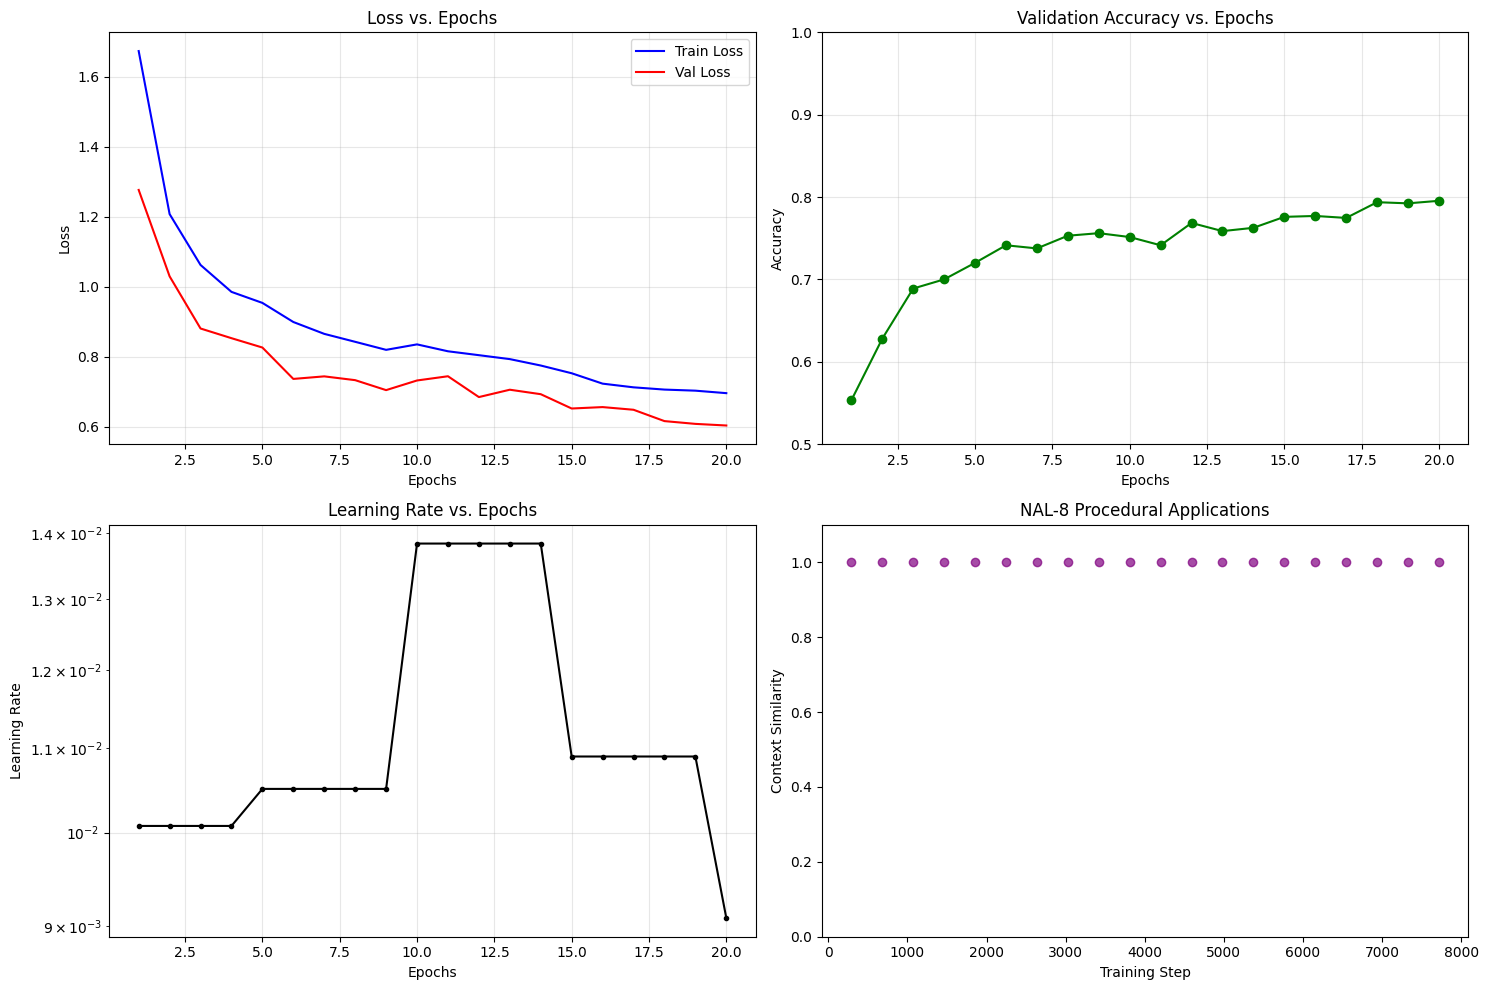

Training complete! Results saved to 'nal_training_results.png'
Model saved to 'nal_trained_model.pth'
Best validation accuracy: 79.55%


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import os
import numpy as np

# Import your enhanced NAL implementation
# Assuming the code is in a file called "enhanced_nal.py"

# Set up device for training
device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, hidden_size=128, dropout=0.2):
        super().__init__()
        # Simple CNN layers to handle the 2D structure and color channels
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 3 input channels for RGB
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32 -> 16x16
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16 -> 8x8
        )
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, hidden_size),  # 64 channels * 8*8 size
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 10)  # 10 classes in CIFAR-10
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Set up data paths and hyperparameters
DATA_ROOT = os.path.join(os.path.expanduser("~"), "data2")
os.makedirs(DATA_ROOT, exist_ok=True)

BATCH_SIZE = 128
EPOCHS = 20
INIT_LR = 0.0001

# Define transforms for the dataset
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # RGB channels
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # RGB channels
])

# Load Fashion MNIST dataset
train_dataset = torchvision.datasets.CIFAR10(
    DATA_ROOT, train=True, download=True, transform=train_transform
)
test_dataset = torchvision.datasets.CIFAR10(
    DATA_ROOT, train=False, download=True, transform=test_transform
)

# Use smaller subset for faster training (optional)
train_subset = Subset(train_dataset, list(range(50000)))
test_subset = Subset(test_dataset, list(range(10000)))

# Create data loaders
train_loader = DataLoader(
    train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

# Initialize model, loss function, and optimizer
model = SimpleNN(hidden_size=128, dropout=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=INIT_LR)

# Train with the enhanced NAL learning rate scheduler
print(f"Starting training with Enhanced NAL LR Tuner for {EPOCHS} epochs...")
print(f"Initial learning rate: {INIT_LR}")

training_history = train_with_enhanced_nal(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    epochs=EPOCHS,
    validation_loader=test_loader,
    debug=True  # Set to False for less verbose output
)

# Plot training results
plt.figure(figsize=(15, 10))

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(range(1, EPOCHS+1), training_history['train_losses'], 'b-', label='Train Loss')
plt.plot(range(1, EPOCHS+1), training_history['val_losses'], 'r-', label='Val Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot validation accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, EPOCHS+1), training_history['val_accuracies'], 'g-', marker='o')
plt.title('Validation Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.grid(True, alpha=0.3)

# Plot learning rate over time
plt.subplot(2, 2, 3)
plt.plot(range(1, EPOCHS+1), training_history['lr_history'], 'k-', marker='.')
plt.title('Learning Rate vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Plot applied procedures (NAL-8)
plt.subplot(2, 2, 4)
if training_history['applied_procedures']:
    applied_steps = [p['step'] for p in training_history['applied_procedures']]
    similarities = [p['similarity'] for p in training_history['applied_procedures']]
    plt.scatter(applied_steps, similarities, c='purple', alpha=0.7)
    plt.title('NAL-8 Procedural Applications')
    plt.xlabel('Training Step')
    plt.ylabel('Context Similarity')
    plt.ylim(0, 1.1)
else:
    plt.text(0.5, 0.5, 'No procedural applications recorded', 
             horizontalalignment='center', verticalalignment='center')
    plt.title('NAL-8 Procedural Applications')

plt.tight_layout()
plt.show()

print("Training complete! Results saved to 'nal_training_results.png'")

# Save model
print("Model saved to 'nal_trained_model.pth'")

# Print best accuracy achieved
best_accuracy = max(training_history['val_accuracies'])
print(f"Best validation accuracy: {best_accuracy:.2%}")



In [10]:
# Print NAL-8 procedural patterns that were learned
if training_history['procedural_patterns']:
    print("\nLearned NAL-8 Procedural Patterns:")
    for i, (context_key, pattern) in enumerate(training_history['procedural_patterns'].items()):
        avg_accuracy = pattern['total_accuracy'] / pattern['count'] if pattern['count'] > 0 else 0
        print(f"Pattern {i+1}: {context_key}")
        print(f"  Count: {pattern['count']}")
        print(f"  Max Accuracy: {pattern['max_accuracy']:.2%}")
        print(f"  Avg Accuracy: {avg_accuracy:.2%}")
        if pattern['lr_values']:
            print(f"  LR Range: {min(pattern['lr_values']):.6f} - {max(pattern['lr_values']):.6f}")
        print()


Learned NAL-8 Procedural Patterns:
Pattern 1: early_medium
  Count: 3
  Max Accuracy: 67.72%
  Avg Accuracy: 62.09%
  LR Range: 0.001007 - 0.001007

Pattern 2: mid_medium
  Count: 7
  Max Accuracy: 76.44%
  Avg Accuracy: 73.67%
  LR Range: 0.000973 - 0.001007

Pattern 3: late_medium
  Count: 10
  Max Accuracy: 78.83%
  Avg Accuracy: 77.58%
  LR Range: 0.000973 - 0.001998



Using device: mps
Starting training with OneCycleLR for 20 epochs...
Initial learning rate: 0.009999999999999995
Maximum learning rate: 0.1
Epoch 1, Batch 50: Loss = 1.8664, LR = 0.010101
Epoch 1, Batch 100: Loss = 1.6288, LR = 0.010403
Epoch 1, Batch 150: Loss = 1.5105, LR = 0.010906
Epoch 1, Batch 200: Loss = 1.4953, LR = 0.011606
Epoch 1, Batch 250: Loss = 1.4505, LR = 0.012500
Epoch 1, Batch 300: Loss = 1.3973, LR = 0.013586
Epoch 1, Batch 350: Loss = 1.3761, LR = 0.014857
Epoch 1/20 completed.
  Train Loss: 0.1389
  Val Loss: 1.1712
  Val Accuracy: 0.5728
  Current LR: 0.016034
Epoch 2, Batch 50: Loss = 1.3028, LR = 0.017628
Epoch 2, Batch 100: Loss = 1.2677, LR = 0.019390
Epoch 2, Batch 150: Loss = 1.2800, LR = 0.021311
Epoch 2, Batch 200: Loss = 1.2682, LR = 0.023383
Epoch 2, Batch 250: Loss = 1.2411, LR = 0.025598
Epoch 2, Batch 300: Loss = 1.2934, LR = 0.027944
Epoch 2, Batch 350: Loss = 1.2377, LR = 0.030411
Epoch 2/20 completed.
  Train Loss: 0.1283
  Val Loss: 1.2290
  Val 

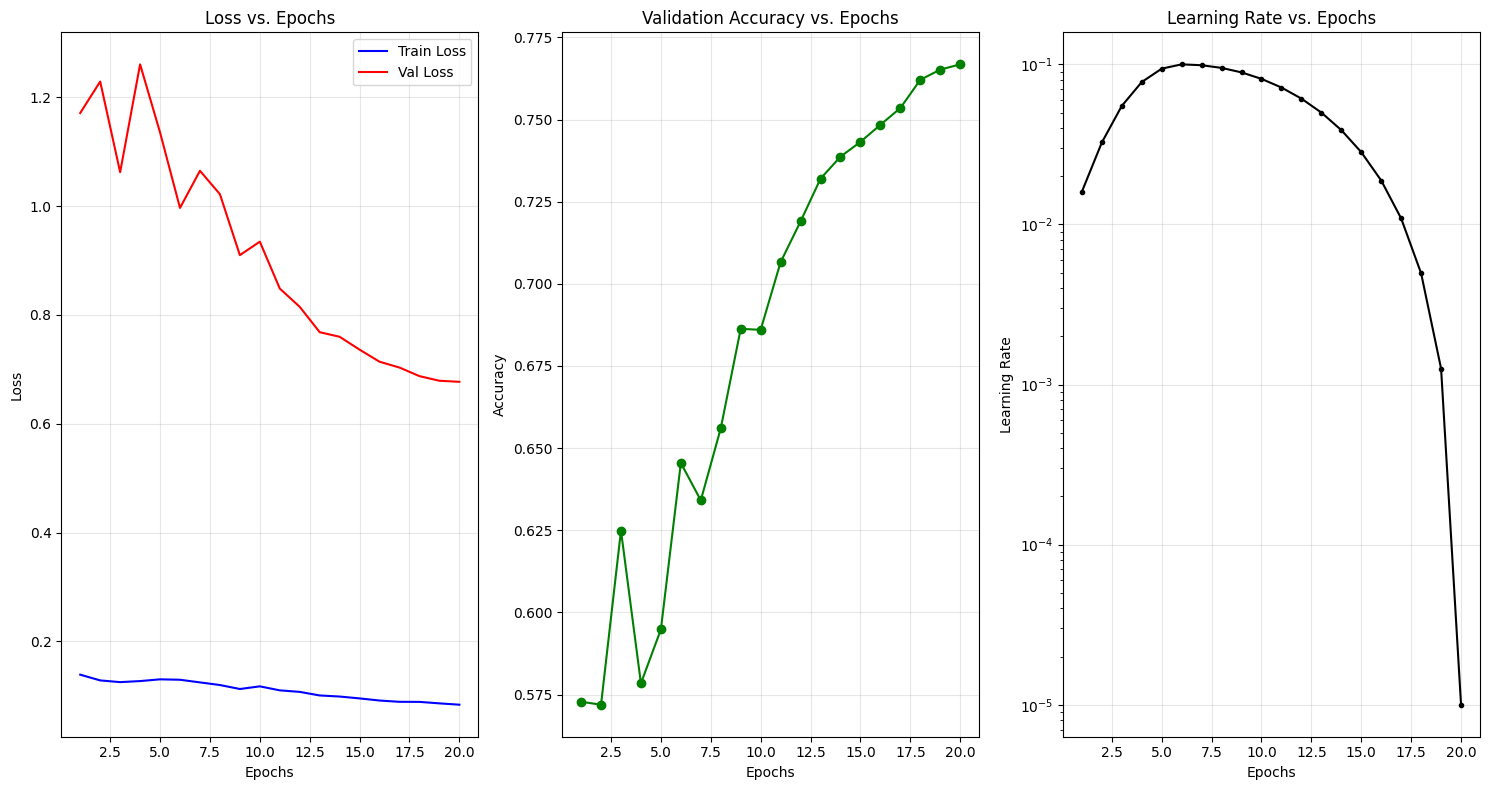

Training complete! Results saved to 'onecycle_training_results.png'
Model saved to 'onecycle_trained_model.pth'
Best validation accuracy: 76.68%


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import os
import numpy as np
from torch.optim.lr_scheduler import OneCycleLR

# Set up device for training
device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, hidden_size=128, dropout=0.2):
        super().__init__()
        # Simple CNN layers to handle the 2D structure and color channels
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 3 input channels for RGB
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32 -> 16x16
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16 -> 8x8
        )
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, hidden_size),  # 64 channels * 8*8 size
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 10)  # 10 classes in CIFAR-10
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Set up data paths and hyperparameters
DATA_ROOT = os.path.join(os.path.expanduser("~"), "data2")
os.makedirs(DATA_ROOT, exist_ok=True)

BATCH_SIZE = 128
EPOCHS = 20
MAX_LR = 0.1

# Define transforms for the dataset
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # RGB channels
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # RGB channels
])

# Load Fashion MNIST dataset
train_dataset = torchvision.datasets.CIFAR10(
    DATA_ROOT, train=True, download=True, transform=train_transform
)
test_dataset = torchvision.datasets.CIFAR10(
    DATA_ROOT, train=False, download=True, transform=test_transform
)

# Use smaller subset for faster training (optional)
train_subset = Subset(train_dataset, list(range(50000)))
test_subset = Subset(test_dataset, list(range(10000)))


# Create data loaders
train_loader = DataLoader(
    train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

# Initialize model, loss function, and optimizer
model = SimpleNN(hidden_size=128, dropout=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=MAX_LR/10)  # Start with lower LR

# Calculate total steps for OneCycleLR
steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * EPOCHS

# Configure the OneCycleLR scheduler
scheduler = OneCycleLR(
    optimizer,
    max_lr=MAX_LR,
    total_steps=total_steps,
    pct_start=0.3,  # Spend 30% of training time in the increasing LR phase
    anneal_strategy='cos',  # Use cosine annealing
    div_factor=10.0,  # Initial learning rate is max_lr/10
    final_div_factor=1000.0  # Final learning rate is max_lr/1000
)

# Training function
def train_model():
    # Initialize history tracking
    train_losses = []
    val_losses = []
    val_accuracies = []
    lr_history = []
    
    # Training loop
    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_loss = 0.0
        
        # Training phase
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update learning rate
            scheduler.step()
            
            # Update statistics
            running_loss += loss.item()
            
            # Print batch progress every 50 batches
            if i % 50 == 49:
                print(f'Epoch {epoch}, Batch {i+1}: Loss = {running_loss/50:.4f}, '
                      f'LR = {scheduler.get_last_lr()[0]:.6f}')
                running_loss = 0.0
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # Calculate epoch statistics
        epoch_train_loss = running_loss / len(train_loader) if running_loss > 0 else 0
        epoch_val_loss = val_loss / len(test_loader)
        epoch_val_acc = correct / total
        
        # Store history
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        lr_history.append(optimizer.param_groups[0]['lr'])
        
        # Print epoch summary
        print(f'Epoch {epoch}/{EPOCHS} completed.')
        print(f'  Train Loss: {epoch_train_loss:.4f}')
        print(f'  Val Loss: {epoch_val_loss:.4f}')
        print(f'  Val Accuracy: {epoch_val_acc:.4f}')
        print(f'  Current LR: {optimizer.param_groups[0]["lr"]:.6f}')
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'lr_history': lr_history
    }

# Train the model
print(f"Starting training with OneCycleLR for {EPOCHS} epochs...")
print(f"Initial learning rate: {optimizer.param_groups[0]['lr']}")
print(f"Maximum learning rate: {MAX_LR}")

training_history1 = train_model()

# Plot training results
plt.figure(figsize=(15, 8))

# Plot training and validation loss
plt.subplot(1, 3, 1)
plt.plot(range(1, EPOCHS+1), training_history1['train_losses'], 'b-', label='Train Loss')
plt.plot(range(1, EPOCHS+1), training_history1['val_losses'], 'r-', label='Val Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot validation accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, EPOCHS+1), training_history1['val_accuracies'], 'g-', marker='o')
plt.title('Validation Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

# Plot learning rate over time
plt.subplot(1, 3, 3)
plt.plot(range(1, EPOCHS+1), training_history1['lr_history'], 'k-', marker='.')
plt.title('Learning Rate vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Training complete! Results saved to 'onecycle_training_results.png'")

# Save model
print("Model saved to 'onecycle_trained_model.pth'")

# Print best accuracy achieved
best_accuracy = max(training_history1['val_accuracies'])
print(f"Best validation accuracy: {best_accuracy:.2%}")

/var/folders/hh/0n3hsq2540902fc99svc3wcm0000gn/T/ipykernel_5224/1213289703.py:3: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(1, EPOCHS+1), training_history['train_losses'], 'b-',linestyle="dashed", label='NARS: Train Loss')
/var/folders/hh/0n3hsq2540902fc99svc3wcm0000gn/T/ipykernel_5224/1213289703.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(1, EPOCHS+1), training_history['val_losses'], 'r-',linestyle="dashed", label='NARS: Val Loss')


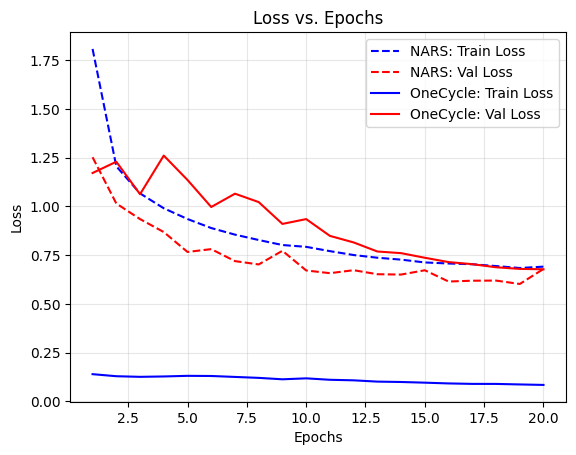

/var/folders/hh/0n3hsq2540902fc99svc3wcm0000gn/T/ipykernel_5224/1213289703.py:16: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(1, EPOCHS+1), training_history1['val_accuracies'], 'g-',linestyle="dashed", marker='o', label="OneCycle")


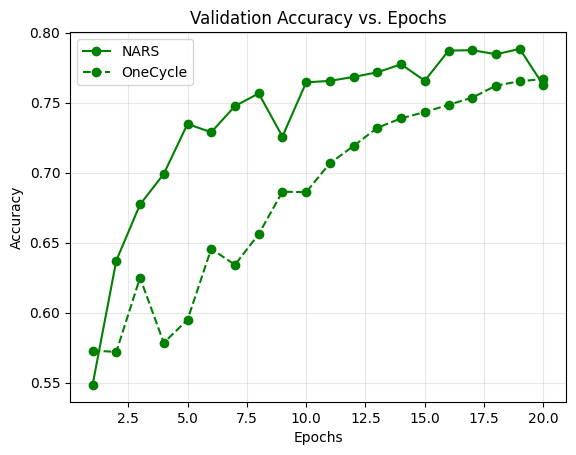

/var/folders/hh/0n3hsq2540902fc99svc3wcm0000gn/T/ipykernel_5224/1213289703.py:26: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(1, EPOCHS+1), training_history1['lr_history'], 'k-',linestyle="dashed", marker='.', label="OneCycle")


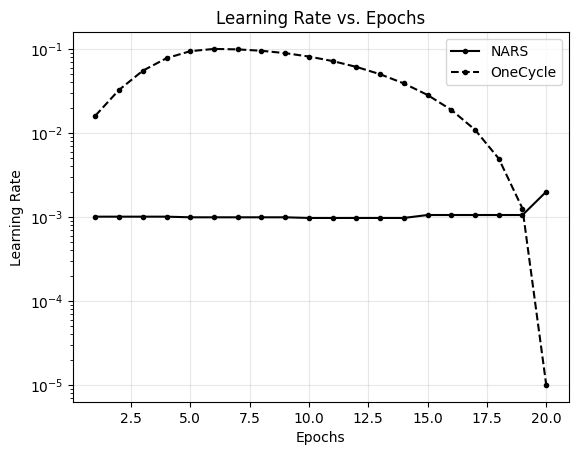

In [13]:

# Plot training and validation loss
plt.figure()
plt.plot(range(1, EPOCHS+1), training_history['train_losses'], 'b-',linestyle="dashed", label='NARS: Train Loss')
plt.plot(range(1, EPOCHS+1), training_history['val_losses'], 'r-',linestyle="dashed", label='NARS: Val Loss')
plt.plot(range(1, EPOCHS+1), training_history1['train_losses'], 'b', label='OneCycle: Train Loss')
plt.plot(range(1, EPOCHS+1), training_history1['val_losses'], 'r', label='OneCycle: Val Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# Plot validation accuracy
plt.figure()
plt.plot(range(1, EPOCHS+1), training_history['val_accuracies'], 'g-', marker='o', label="NARS")
plt.plot(range(1, EPOCHS+1), training_history1['val_accuracies'], 'g-',linestyle="dashed", marker='o', label="OneCycle")
plt.title('Validation Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# Plot learning rate over time
plt.figure()
plt.plot(range(1, EPOCHS+1), training_history['lr_history'], 'k-', marker='.', label="NARS")
plt.plot(range(1, EPOCHS+1), training_history1['lr_history'], 'k-',linestyle="dashed", marker='.', label="OneCycle")
plt.title('Learning Rate vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

In [14]:
for i in range(len(training_history1['val_accuracies'])):
    training_history['val_accuracies'][i]=100*training_history['val_accuracies'][i]
    training_history1['val_accuracies'][i]=100*training_history1['val_accuracies'][i]
                   

In [15]:
print(max(training_history['train_losses']))
print(max(training_history['val_losses']))

print(max(training_history1['train_losses']))
print(max(training_history1['val_losses']))

print(max(training_history2['train_losses']))
print(max(training_history2['val_losses']))

1.8079203842850902
1.2520739277706872
0.13887232801188593
1.2606145596202416


NameError: name 'training_history2' is not defined

/var/folders/hh/0n3hsq2540902fc99svc3wcm0000gn/T/ipykernel_5224/1755058589.py:3: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(1, EPOCHS+1), training_history['train_losses'], 'b-',linestyle="dashed", label='NARS: Train Loss')
/var/folders/hh/0n3hsq2540902fc99svc3wcm0000gn/T/ipykernel_5224/1755058589.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(1, EPOCHS+1), training_history['val_losses'], 'r-',linestyle="dashed", label='NARS: Val Loss')


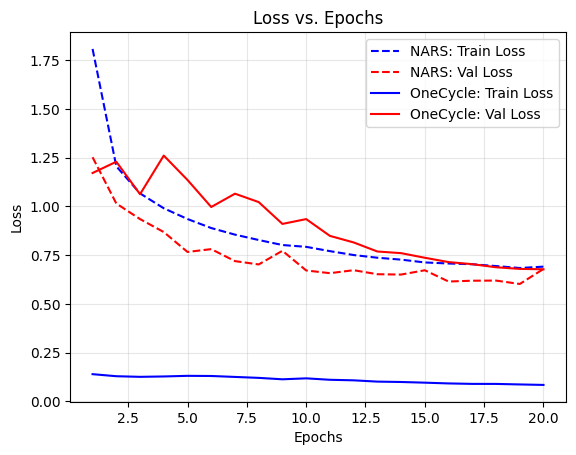

/var/folders/hh/0n3hsq2540902fc99svc3wcm0000gn/T/ipykernel_5224/1755058589.py:16: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(1, EPOCHS+1), training_history1['val_accuracies'], 'g-',linestyle="dashed", marker='o', label="OneCycle")


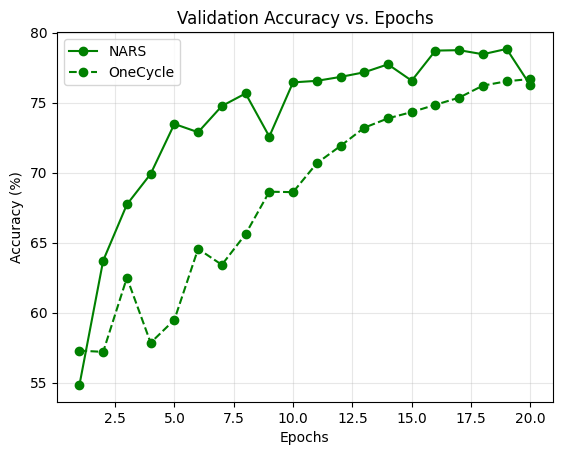

/var/folders/hh/0n3hsq2540902fc99svc3wcm0000gn/T/ipykernel_5224/1755058589.py:26: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(1, EPOCHS+1), training_history1['lr_history'], 'k-',linestyle="dashed", marker='.', label="OneCycle")


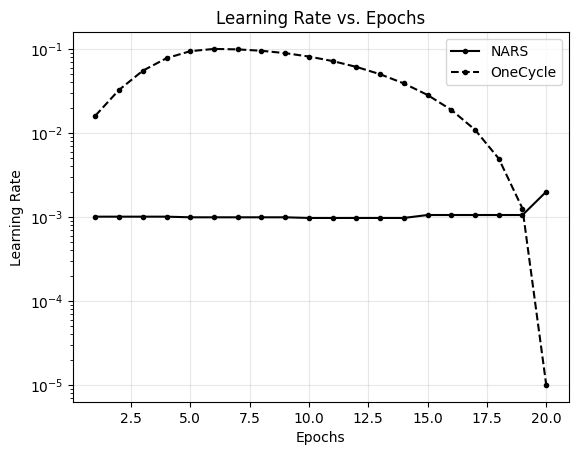

In [16]:

# Plot training and validation loss
plt.figure()
plt.plot(range(1, EPOCHS+1), training_history['train_losses'], 'b-',linestyle="dashed", label='NARS: Train Loss')
plt.plot(range(1, EPOCHS+1), training_history['val_losses'], 'r-',linestyle="dashed", label='NARS: Val Loss')
plt.plot(range(1, EPOCHS+1), training_history1['train_losses'], 'b', label='OneCycle: Train Loss')
plt.plot(range(1, EPOCHS+1), training_history1['val_losses'], 'r', label='OneCycle: Val Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# Plot validation accuracy
plt.figure()
plt.plot(range(1, EPOCHS+1), training_history['val_accuracies'], 'g-', marker='o', label="NARS")
plt.plot(range(1, EPOCHS+1), training_history1['val_accuracies'], 'g-',linestyle="dashed", marker='o', label="OneCycle")
plt.title('Validation Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# Plot learning rate over time
plt.figure()
plt.plot(range(1, EPOCHS+1), training_history['lr_history'], 'k-', marker='.', label="NARS")
plt.plot(range(1, EPOCHS+1), training_history1['lr_history'], 'k-',linestyle="dashed", marker='.', label="OneCycle")
plt.title('Learning Rate vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

Using device: mps
Starting training with fixed learning rate Adam for 20 epochs...
Learning rate: 0.001
Epoch 1, Batch 50: Loss = 1.7992, LR = 0.001000
Epoch 1, Batch 100: Loss = 1.5267, LR = 0.001000
Epoch 1, Batch 150: Loss = 1.4172, LR = 0.001000
Epoch 1, Batch 200: Loss = 1.3653, LR = 0.001000
Epoch 1, Batch 250: Loss = 1.3108, LR = 0.001000
Epoch 1, Batch 300: Loss = 1.2845, LR = 0.001000
Epoch 1, Batch 350: Loss = 1.2383, LR = 0.001000
Epoch 1/20 completed.
  Train Loss: 1.1987
  Val Loss: 1.0732
  Val Accuracy: 0.6180
  Learning Rate: 0.001000
Epoch 2, Batch 50: Loss = 1.1568, LR = 0.001000
Epoch 2, Batch 100: Loss = 1.1353, LR = 0.001000
Epoch 2, Batch 150: Loss = 1.1301, LR = 0.001000
Epoch 2, Batch 200: Loss = 1.1256, LR = 0.001000
Epoch 2, Batch 250: Loss = 1.1010, LR = 0.001000
Epoch 2, Batch 300: Loss = 1.0808, LR = 0.001000
Epoch 2, Batch 350: Loss = 1.0754, LR = 0.001000
Epoch 2/20 completed.
  Train Loss: 1.0887
  Val Loss: 0.9387
  Val Accuracy: 0.6730
  Learning Rate:

OSError: [Errno 30] Read-only file system: 'adam_fixed_lr_results.png'

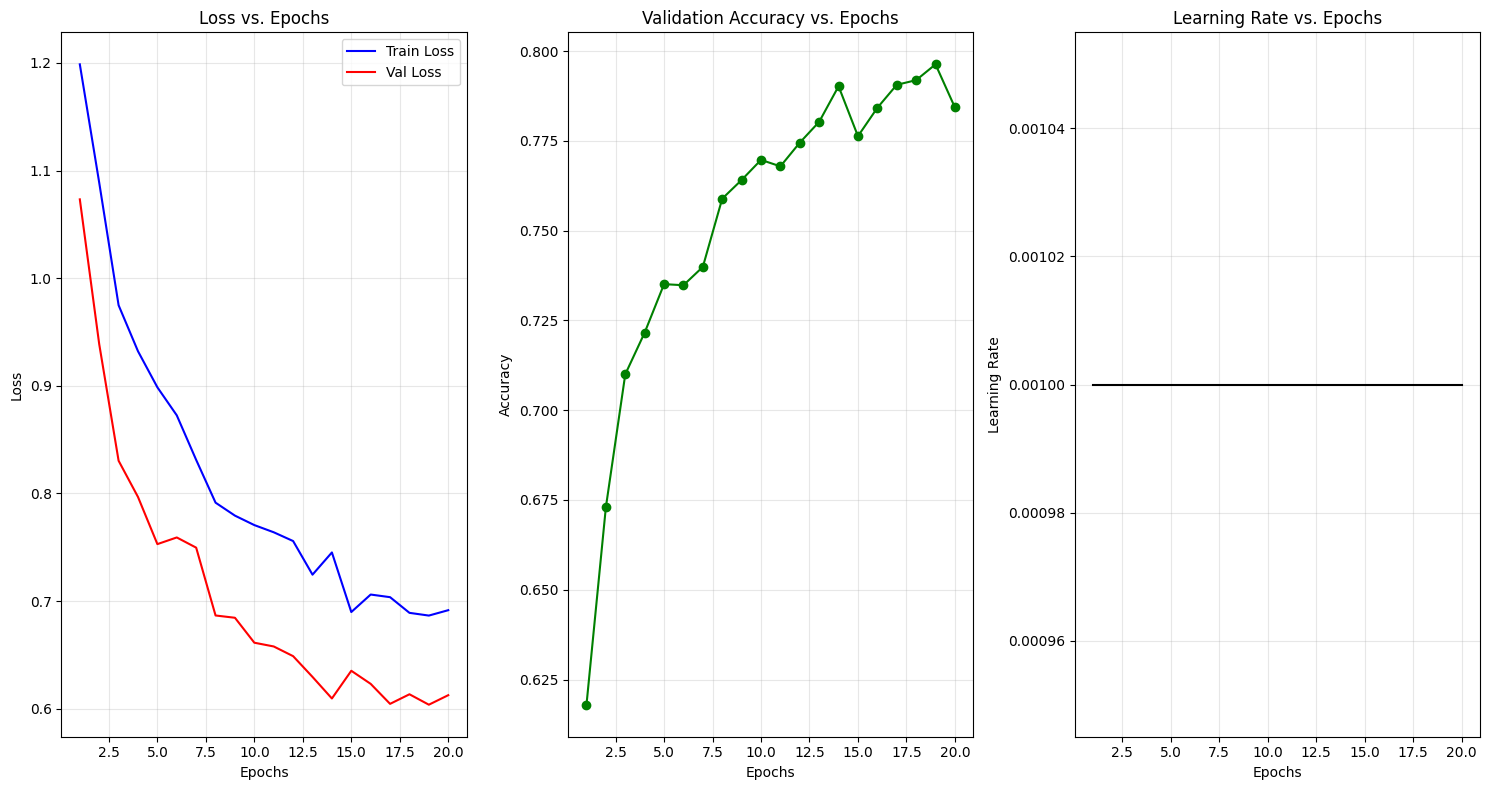

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import os
import numpy as np

# Set up device for training
device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

class SimpleNN(nn.Module):
    def __init__(self, hidden_size=128, dropout=0.2):
        super().__init__()
        # Simple CNN layers to handle the 2D structure and color channels
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 3 input channels for RGB
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32 -> 16x16
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16 -> 8x8
        )
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, hidden_size),  # 64 channels * 8*8 size
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 10)  # 10 classes in CIFAR-10
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Set up data paths and hyperparameters
DATA_ROOT = os.path.join(os.path.expanduser("~"), "data2")
os.makedirs(DATA_ROOT, exist_ok=True)

BATCH_SIZE = 128
EPOCHS = 20
INIT_LR = 0.001

# Define transforms for the dataset
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # RGB channels
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # RGB channels
])

# Load Fashion MNIST dataset
train_dataset = torchvision.datasets.CIFAR10(
    DATA_ROOT, train=True, download=True, transform=train_transform
)
test_dataset = torchvision.datasets.CIFAR10(
    DATA_ROOT, train=False, download=True, transform=test_transform
)

# Use smaller subset for faster training (optional)
train_subset = Subset(train_dataset, list(range(50000)))
test_subset = Subset(test_dataset, list(range(10000)))

# Create data loaders
train_loader = DataLoader(
    train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

# Initialize model, loss function, and optimizer
model = SimpleNN(hidden_size=128, dropout=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=INIT_LR)  # Fixed learning rate

# Training function
def train_model():
    # Initialize history tracking
    train_losses = []
    val_losses = []
    val_accuracies = []
    lr_history = []
    
    # Training loop
    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_loss = 0.0
        batch_count = 0
        
        # Training phase
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update statistics
            running_loss += loss.item()
            batch_count += 1
            
            # Print batch progress every 50 batches
            if i % 50 == 49:
                print(f'Epoch {epoch}, Batch {i+1}: Loss = {running_loss/50:.4f}, '
                      f'LR = {optimizer.param_groups[0]["lr"]:.6f}')
                running_loss = 0.0
                batch_count = 0
        
        # Calculate epoch training loss
        epoch_train_loss = running_loss / batch_count if batch_count > 0 else running_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # Calculate epoch statistics
        epoch_val_loss = val_loss / len(test_loader)
        epoch_val_acc = correct / total
        
        # Store history
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        lr_history.append(optimizer.param_groups[0]['lr'])
        
        # Print epoch summary
        print(f'Epoch {epoch}/{EPOCHS} completed.')
        print(f'  Train Loss: {epoch_train_loss:.4f}')
        print(f'  Val Loss: {epoch_val_loss:.4f}')
        print(f'  Val Accuracy: {epoch_val_acc:.4f}')
        print(f'  Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'lr_history': lr_history
    }

# Train the model
print(f"Starting training with fixed learning rate Adam for {EPOCHS} epochs...")
print(f"Learning rate: {INIT_LR}")

training_history2 = train_model()

# Plot training results
plt.figure(figsize=(15, 8))

# Plot training and validation loss
plt.subplot(1, 3, 1)
plt.plot(range(1, EPOCHS+1), training_history2['train_losses'], 'b-', label='Train Loss')
plt.plot(range(1, EPOCHS+1), training_history2['val_losses'], 'r-', label='Val Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot validation accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, EPOCHS+1), training_history2['val_accuracies'], 'g-', marker='o')
plt.title('Validation Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

# Plot learning rate over time (will be constant)
plt.subplot(1, 3, 3)
plt.plot(range(1, EPOCHS+1), training_history2['lr_history'], 'k-')
plt.title('Learning Rate vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('adam_fixed_lr_results.png')
plt.show()

print("Training complete! Results saved to 'adam_fixed_lr_results.png'")

# Print best accuracy achieved
best_accuracy = max(training_history2['val_accuracies'])
print(f"Best validation accuracy: {best_accuracy:.2%}")

In [25]:
for i in range(len(training_history1['val_accuracies'])):
    training_history2['val_accuracies'][i]=100*training_history2['val_accuracies'][i]
                   

/var/folders/hh/0n3hsq2540902fc99svc3wcm0000gn/T/ipykernel_5224/2887544624.py:3: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "y-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(1, EPOCHS+1), training_history['train_losses'], 'y-',linestyle="dashed", marker='o', label='NARS: Train Loss')


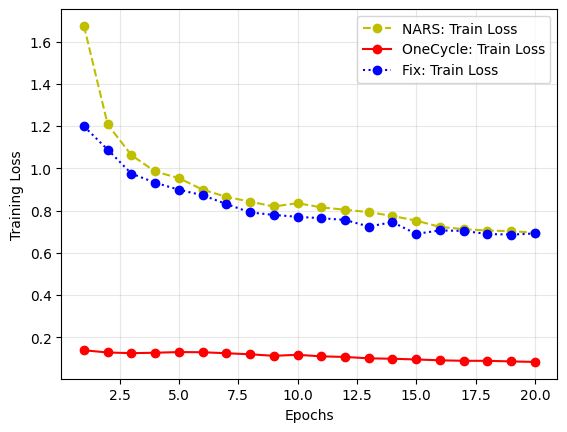

/var/folders/hh/0n3hsq2540902fc99svc3wcm0000gn/T/ipykernel_5224/2887544624.py:14: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "y-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(1, EPOCHS+1), training_history['val_losses'], 'y-', marker='o',linestyle="dashed", label='NARS: Val Loss')


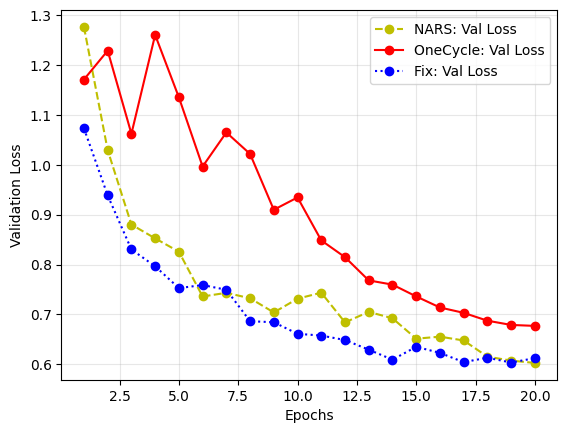

/var/folders/hh/0n3hsq2540902fc99svc3wcm0000gn/T/ipykernel_5224/2887544624.py:26: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(1, EPOCHS+1), training_history1['val_accuracies'], 'r-',linestyle="dashed", marker='o', label="OneCycle")
/var/folders/hh/0n3hsq2540902fc99svc3wcm0000gn/T/ipykernel_5224/2887544624.py:27: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(1, EPOCHS+1), training_history2['val_accuracies'], 'b-',linestyle="dotted", marker='o', label="Fix")


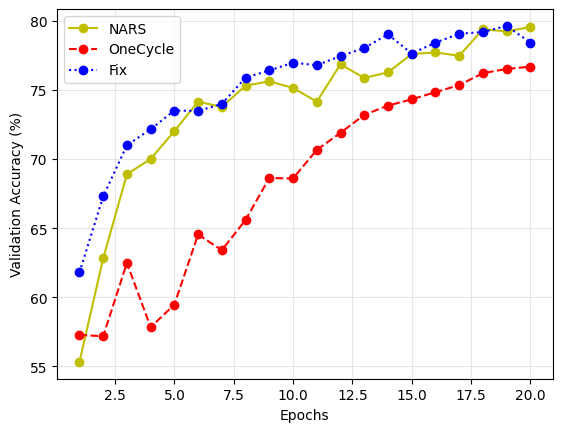

/var/folders/hh/0n3hsq2540902fc99svc3wcm0000gn/T/ipykernel_5224/2887544624.py:38: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(1, EPOCHS+1), training_history1['lr_history'], 'r-',linestyle="dashed", marker='.', label="OneCycle")
/var/folders/hh/0n3hsq2540902fc99svc3wcm0000gn/T/ipykernel_5224/2887544624.py:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(1, EPOCHS+1), training_history2['lr_history'], 'b-',linestyle="dotted", marker='.', label="Fixed")


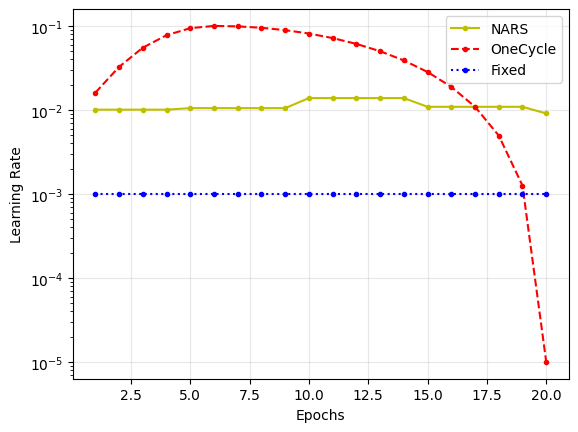

In [34]:

# Plot training and validation loss
plt.figure()
plt.plot(range(1, EPOCHS+1), training_history['train_losses'], 'y-',linestyle="dashed", marker='o', label='NARS: Train Loss')
plt.plot(range(1, EPOCHS+1), training_history1['train_losses'], 'r', label='OneCycle: Train Loss', marker='o')
plt.plot(range(1, EPOCHS+1), training_history2['train_losses'], 'b',linestyle="dotted", marker='o', label='Fix: Train Loss')
#plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot(range(1, EPOCHS+1), training_history['val_losses'], 'y-', marker='o',linestyle="dashed", label='NARS: Val Loss')
plt.plot(range(1, EPOCHS+1), training_history1['val_losses'], 'r', marker='o', label='OneCycle: Val Loss')
plt.plot(range(1, EPOCHS+1), training_history2['val_losses'], 'b',linestyle="dotted", marker='o', label='Fix: Val Loss')
#plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# Plot validation accuracy
plt.figure()
plt.plot(range(1, EPOCHS+1), training_history['val_accuracies'], 'y-', marker='o', label="NARS")
plt.plot(range(1, EPOCHS+1), training_history1['val_accuracies'], 'r-',linestyle="dashed", marker='o', label="OneCycle")
plt.plot(range(1, EPOCHS+1), training_history2['val_accuracies'], 'b-',linestyle="dotted", marker='o', label="Fix")

#plt.title('Validation Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# Plot learning rate over time
plt.figure()
plt.plot(range(1, EPOCHS+1), training_history['lr_history'], 'y-', marker='.', label="NARS")
plt.plot(range(1, EPOCHS+1), training_history1['lr_history'], 'r-',linestyle="dashed", marker='.', label="OneCycle")
plt.plot(range(1, EPOCHS+1), training_history2['lr_history'], 'b-',linestyle="dotted", marker='.', label="Fixed")
#plt.title('Learning Rate vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

In [33]:
for i in range(len(training_history1['val_accuracies'])):
    training_history['val_accuracies'][i]=(100)*training_history['val_accuracies'][i]
                   

In [42]:
print(min(training_history['train_losses']))

print(min(training_history1['train_losses']))
print(min(training_history2['train_losses']))

print(min(training_history['val_losses']))

print(min(training_history1['val_losses']))

print(min(training_history2['val_losses']))

print((training_history['val_accuracies'])[-1])

print((training_history1['val_accuracies'])[-1])

print((training_history2['val_accuracies'])[-1])


0.6954204096361194
0.08370248634187157
0.686483713184915
0.6029066779190981
0.6771663378311109
0.6036666526070124
79.55
76.68
78.43
